# Data Lab 8
Prediction with the periodic AR2 model. Skill of deterministic forecasts (single number).

In [37]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [38]:
def cor(x,y):
    xa = x - np.nanmean(x)
    ya = y - np.nanmean(y)
    return np.nansum(xa*ya)/np.sqrt(np.nansum(xa**2)*np.nansum(ya**2))

In [39]:
# Read nino 3.4 and compute anomalies
n34_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34/dods'
n34_ds = xr.open_dataset(n34_url)
n34 = n34_ds.n34
nmonths = len(n34)
n34a = n34.groupby('T.month') - n34.groupby('T.month').mean()

## Comments on homework 6

### 1. Variance of the sample mean

![](images/VarSampleMean.pdf)

Sampling error of the mean is larger when ACF > 0. There are not as many independent samples.

### 2. The stationary distribution of an AR(1) model

$$ N \left( \frac{k}{1 - \phi}, \frac{\sigma_W^2}{1 - \phi^2} \right) $$

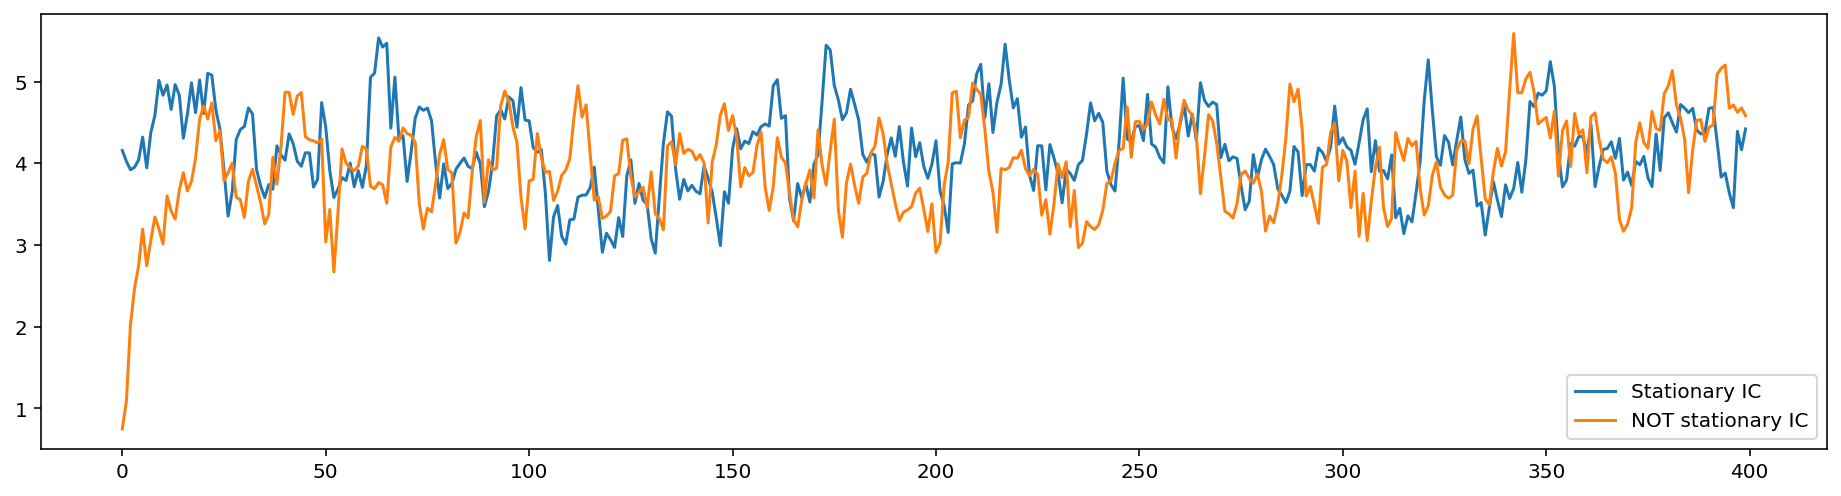

In [40]:
N = 400
phi = 0.75
k = 1.0
sigma_W = np.sqrt(0.1)

mu = k/(1 - phi)
sigma_X = np.sqrt(sigma_W**2 / (1 - phi**2))

fig, ax = plt.subplots(figsize = (16,4))

x = np.empty(N) + np.nan
x[0] = np.random.normal(loc = mu, scale = sigma_X)
for ii in range(1, N):
    x[ii] = phi * x[ii - 1] + k + np.random.normal(scale = sigma_W)

ax.plot(x, label = 'Stationary IC');

x = np.empty(N) + np.nan
x[0] = 0.75
for ii in range(1, N):
    x[ii] = phi * x[ii - 1] + k + np.random.normal(scale = sigma_W)

ax.plot(x, label = 'NOT stationary IC');
ax.legend();

The process becomes stationary as it forgets about the IC. 

$$ p(X_t | x_0) \rightarrow p(X_t) $$

### 4. Fitting Nino 3.4 with an AR(1) model

#### 4.1. Tricky bug!

$$ X_{t} - \phi X_{t-1} = W_t $$

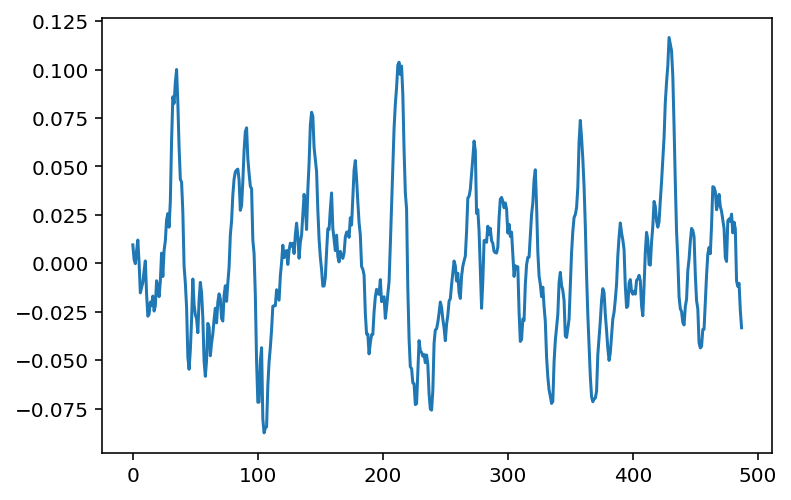

In [41]:
phi = 0.957
Xt = n34a[1:]
Xt_1 = n34a[:-1]
R1 = Xt - phi*Xt_1
plt.plot(R1);

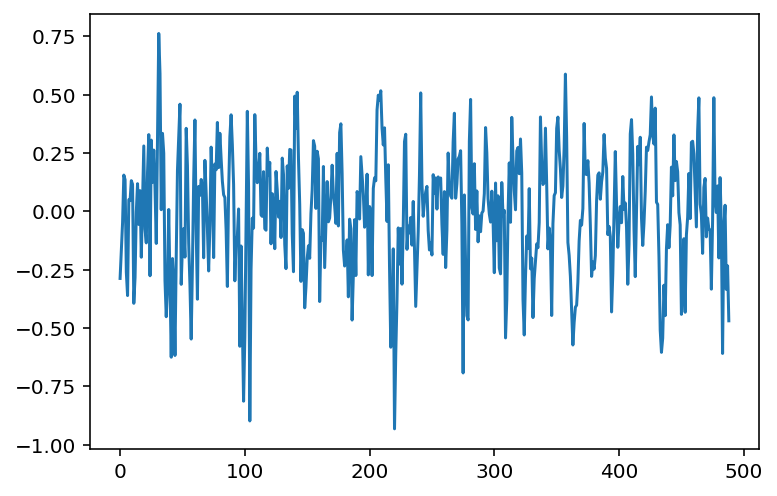

In [42]:
phi = 0.957
Xt = n34a[1:].values
Xt_1 = n34a[:-1].values
R = Xt - phi*Xt_1
plt.plot(R);

Are these the correlated residuals that we expect?

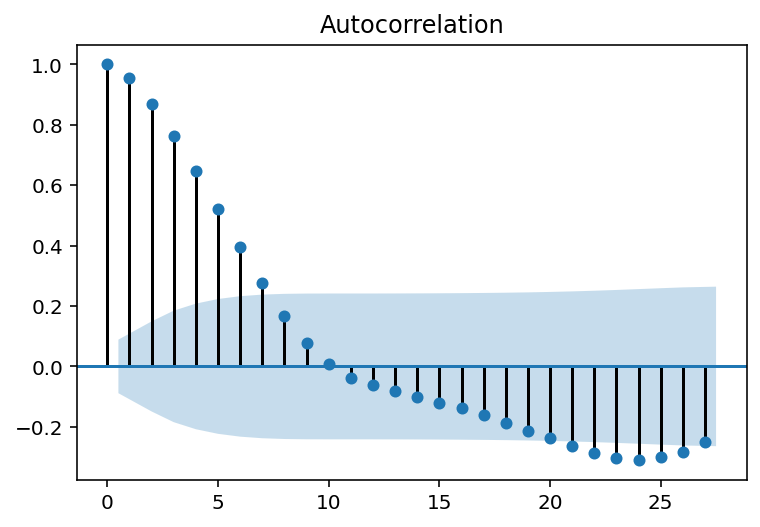

In [43]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(R1);

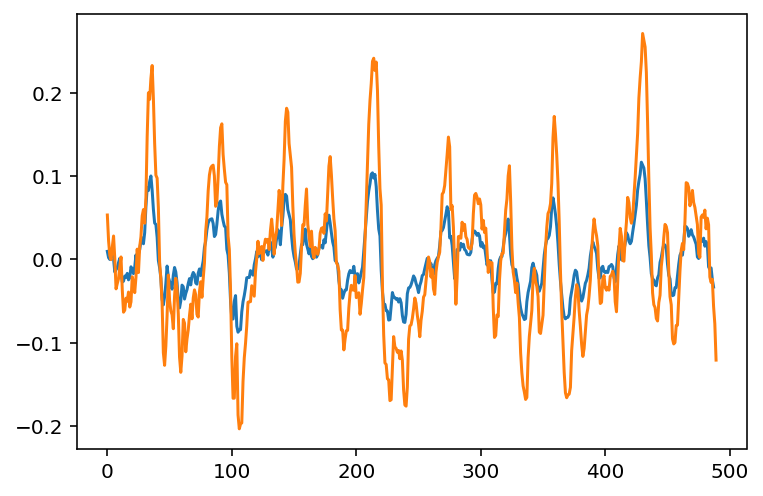

In [44]:
plt.plot(R1)
plt.plot(0.1*n34a);

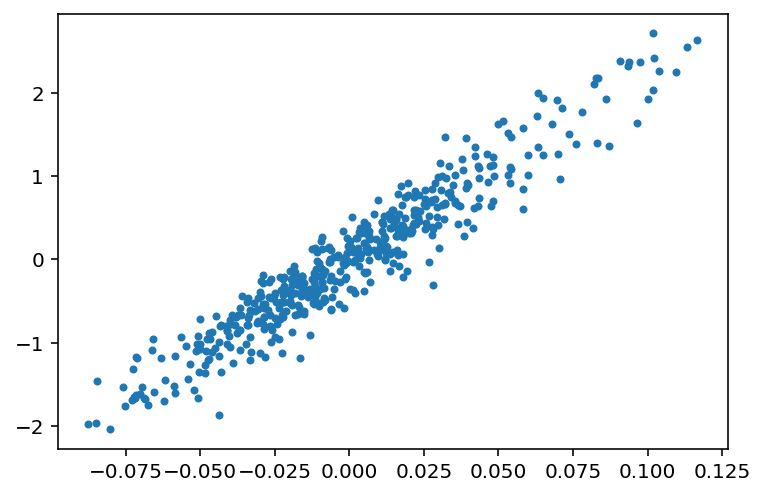

In [45]:
plt.plot(R1, n34a[2:], '.');

#### Why do the residuals look like Nino 3.4 instead of noise?

In [46]:
## What is going one? How to figure it out?

#### 4.2 "I'm unsure why the sample autocorrelation of Nino 3.4 diverges so much from the AR(1) autocorrelation"

This is a great question. Your job is to question everything that you are unsure of.

Obvious (and not informative answer). Nino 3.4 is not well described by an AR(1) model.

Jensen's inequality.

What *might* be happening? Imagining the worst is good skill.

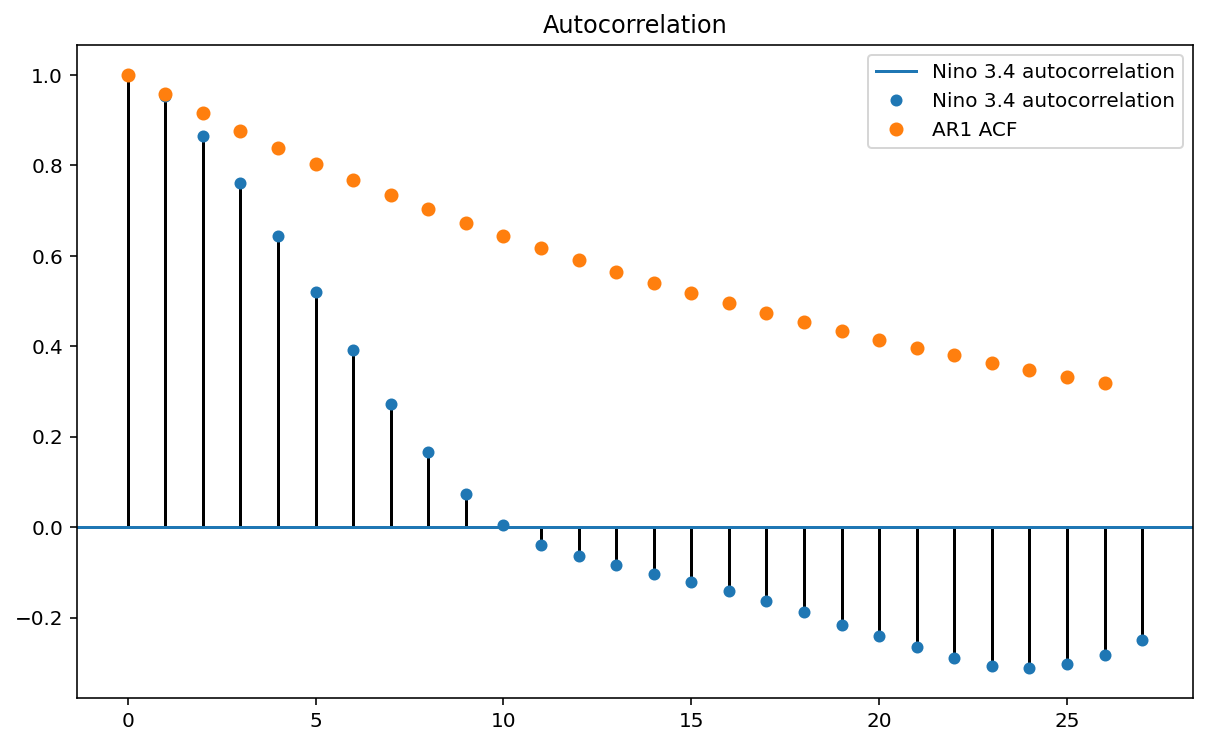

In [47]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize = (10, 6))
#plot_acf(np.random.normal(size=nmonths), alpha = 0.05, ax = ax, title = 'Nino 3.4 autocorrelation');
plot_acf(n34a.values, alpha = None, ax = ax, label = 'Nino 3.4 autocorrelation');
ax.plot(phi**np.arange(0, 27), 'o', label = 'AR1 ACF')
ax.legend();

Spring predictability barrier.

## 1. Skill

We started talking about autoregressive models with the promise that they could be used to make forecasts.

As always, the best forecast we can make now of $X_t$ (in the future) is the conditional distribution

$$ p(X_t | \text{what we know now})$$

Recall that we only need to condition on things that are related to $X_t$.

"Deterministic" refers to the format of forecast. For instance, a single number. The best single number is 

$$ E[ X_t | \text{what we know now})$$

### 1.1 Measures of skill for deterministic (single number) forecasts

Project idea?

[Deterministic skill of ENSO predictions from the North American Multimodel Ensemble](https://link.springer.com/article/10.1007/s00382-017-3603-3)

### 1.1.1 Correlation

Compute the correlation between forecasts and observations. Sometimes called *anomaly correlation* to emphasize the mean (or annual cycle) is removed. For forecast and observation anomalies, $f_i$ and $o_i$, respectively, 

$$ \text{AC} = \frac{\sum_{i=1}^n f_i o_i}{\sqrt{\sum_{i=1}^n f_i^2} \sqrt{\sum_{i=1}^n o_i^2}} $$



The correlation (skill) of an AR(1) forecast is the same as the sample autocorrelation.
Why? ($\tau$ is the lead time.)

$$ E[X_{\tau} | x_0] = \phi^{\tau} x_0 $$

($k = 0$)

Because $\text{cor} [X_{\tau}, \phi^{\tau} x_0] = \text{cor} [X_{\tau},  x_0] $

Whether as a function of lead time only or a function of start month and lead time.


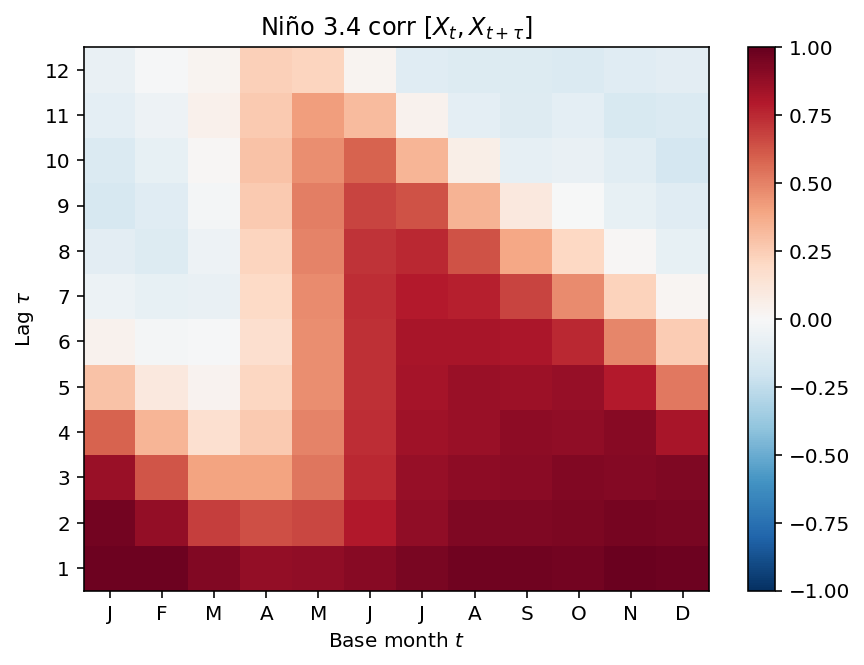

In [48]:
max_lag = 12
cc = np.empty((12,12))
for imonth in range(0, 12):
    for lag in range(1, max_lag + 1):
        cc[lag - 1, imonth] = cor(n34a[imonth::12], n34a.shift(T = -lag)[imonth::12])

fig, ax = plt.subplots(figsize = (7, 5))        
g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, max_lag + 1) + 0.5, cc, vmax=1, vmin=-1, cmap='RdBu_r')
ax.set_xticks(np.arange(0, 12) + 0.5)
ax.set_xticklabels(m_str)
ax.set_yticks(np.arange(1, max_lag + 1))
plt.colorbar(g)
ax.set_xlabel('Base month $t$')
ax.set_ylabel(r'Lag $\tau$')
ax.set_title(r'Niño 3.4 corr $[X_t, X_{t + \tau}]$');

The ACF is the correlation skill of an AR(1) forecast.

### 1.1.2 Mean square error

$$ \text{MSE} = \frac{1}{n} \sum_{i=1}^n (f_i - o_i)^2 $$

Has units. Good or bad?

### 1.1.3 Mean square error skill score

$$ \text{MSESS} = 1 - \frac{\frac{1}{n} \sum_{i=1}^n (f_i - o_i)^2}{\frac{1}{n} \sum_{i=1}^n o_i^2} $$



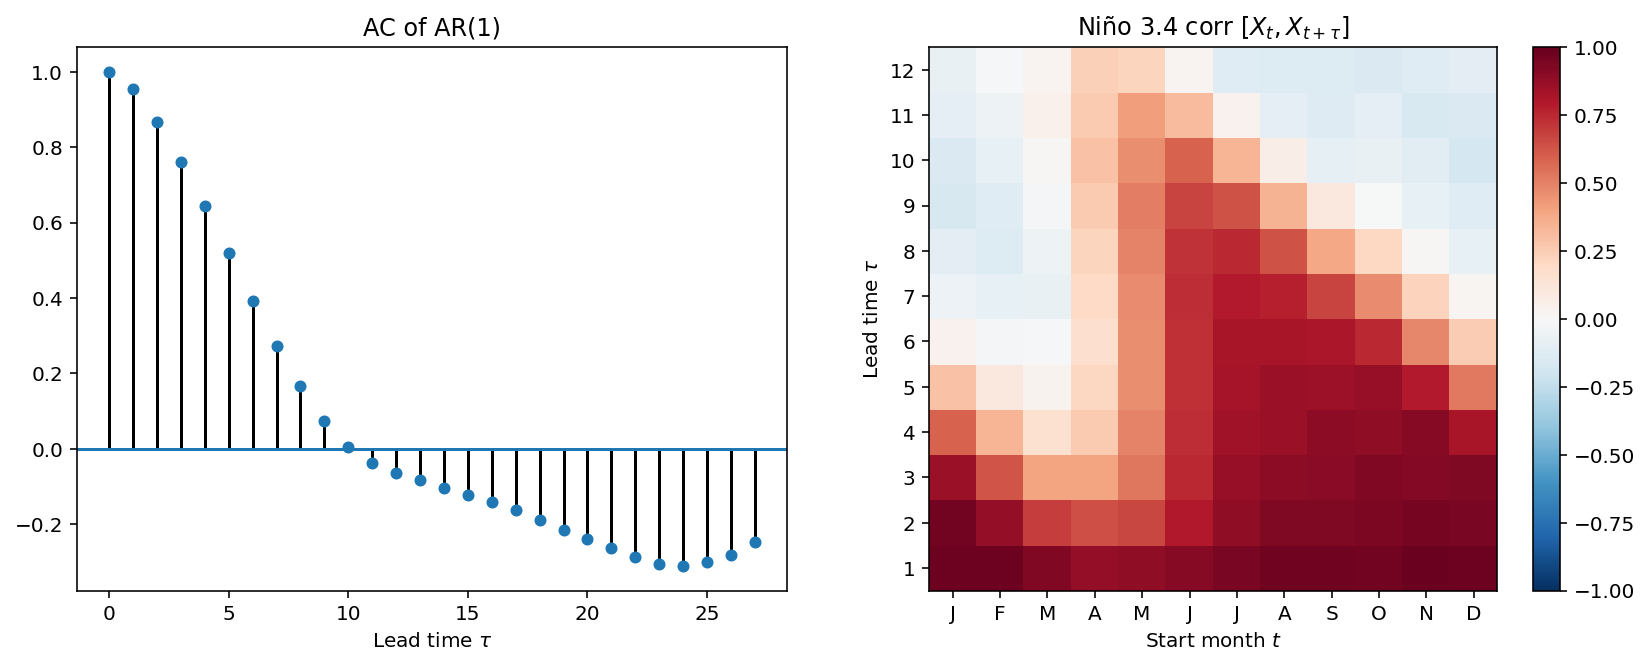

In [49]:
max_lag = 12
cc = np.empty((12,12))
for imonth in range(0, 12):
    for lag in range(1, max_lag + 1):
        cc[lag - 1, imonth] = cor(n34a[imonth::12], n34a.shift(T = -lag)[imonth::12])

fig, axs = plt.subplots(1, 2, figsize = (14, 5))        
plot_acf(n34a, alpha = None, ax = axs[0], title = 'AC of AR(1)')
axs[0].set_xlabel(r'Lead time $\tau$')


ax = axs[1]
g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, max_lag + 1) + 0.5, cc, vmax=1, vmin=-1, cmap='RdBu_r')
ax.set_xticks(np.arange(0, 12) + 0.5)
ax.set_xticklabels(m_str)
ax.set_yticks(np.arange(1, max_lag + 1))
plt.colorbar(g)
ax.set_xlabel('Start month $t$')
ax.set_ylabel(r'Lead time $\tau$')
ax.set_title(r'Niño 3.4 corr $[X_t, X_{t + \tau}]$');

## 2. Let's forecast!

### 2.1 Periodic AR(1) as example

$$ X_{t} = \phi(t) X_{t-1} + W_t $$

where $\phi(t + 12) = \phi(t)$.

One approach: expand $\phi(t)$ in a Fourier series.

One harmonic $\phi(t) = a_0 + a_1 \sin (2\pi t/12) + b_1 \cos (2\pi t/12) $

$$ X_{t} = \left( a_0 + a_1 \sin (2\pi t/12) + b_1 \cos (2\pi t/12) \right) X_{t-1} + W_t $$

This form 
$$ X_{t} =  a_0 X_{t-1} + a_1 \sin (2\pi t/12) X_{t-1} + b_1 \cos (2\pi t/12) X_{t-1} + W_t $$

Two harmonics $\phi(t) = a_0 + a_1 \sin (2\pi t/12) + b_1 \cos (2\pi t/12) + a_2 \sin (4\pi t/12) + b_2 \cos (4\pi t/12) $

In [50]:
# one harmonic in Fourier series
from numpy.linalg import inv

y = n34a[1:].values
N = len(y)

# NOTE we start at 1 here so that 0 is January
# Not essential to make this choice but essential to keep up with it.
t_first = 1
mt = np.arange(1, N + t_first)/12.*2*np.pi

X = np.empty((N,4)) + np.nan
X[:, 0] = 1.
X[:, 1] = n34a[0:-1]
X[:, 2] = n34a[0:-1] * np.sin(mt)
X[:, 3] = n34a[0:-1] * np.cos(mt)

beta = inv(X.T@X)@X.T@y
yhat = X@beta
R = y - yhat
sigma_R = np.std(R, ddof = 4)

beta1h = beta
sigma_W = sigma_R

In [51]:
# two harmonics in Fourier series
from numpy.linalg import inv

y = n34a[1:].values
N = len(y)

mt = np.arange(1, N + 1)/12.*2*np.pi

X = np.empty((N,6)) + np.nan
X[:, 0] = 1.
X[:, 1] = n34a[0:-1]
X[:, 2] = n34a[0:-1] * np.sin(mt)
X[:, 3] = n34a[0:-1] * np.cos(mt)
X[:, 4] = n34a[0:-1] * np.sin(2*mt)
X[:, 5] = n34a[0:-1] * np.cos(2*mt)

beta2h = inv(X.T@X)@X.T@y

In [52]:
# all 12 starts separately
from numpy.linalg import inv

B = np.empty(12) + np.nan

for istart in range(0, 12):
    y = n34a[(istart + 1)::12].values
    N = len(y)

    X = np.empty((N,2)) + np.nan
    X[:, 0] = 1.
    X[:, 1] = n34a[istart:-1:12]

    beta12 = inv(X.T@X)@X.T@y
    B[istart] = beta12[1]

# first element of B is Jan
print(B)
B = np.roll(B, 1)
print(B)

[0.8243003  0.7485877  0.75414438 0.88164987 0.90540381 1.0020421
 1.07253597 1.10108992 1.1611737  1.10482    1.02630241 0.94323616]
[0.94323616 0.8243003  0.7485877  0.75414438 0.88164987 0.90540381
 1.0020421  1.07253597 1.10108992 1.1611737  1.10482    1.02630241]


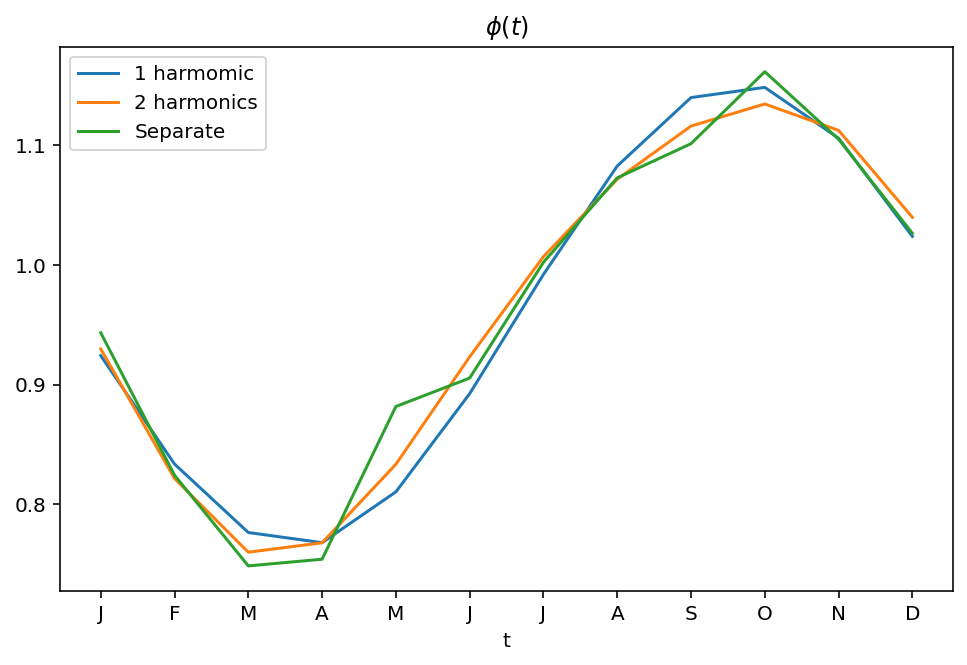

In [53]:
N = 12
mt = np.arange(0, N)/12.*2*np.pi

phi1h = beta1h[1:] @ np.array([np.ones(N), np.sin(mt), np.cos(mt)])
phi2h = beta2h[1:] @ np.array([np.ones(N), np.sin(mt), np.cos(mt), np.sin(2*mt), np.cos(2*mt)])

fig, ax = plt.subplots(figsize =(8, 5))    

ax.plot(phi1h, label = '1 harmomic')
ax.plot(phi2h, label = '2 harmonics')

ax.plot(B, label = 'Separate')
ax.set_xticks(np.arange(0,12));
ax.set_xticklabels(m_str);
ax.set_xlabel('t')
ax.set_title('$\phi(t)$')
ax.legend();

Which one fits the data better? (Smallest residuals) Why?

Which one might be better in "practice"?

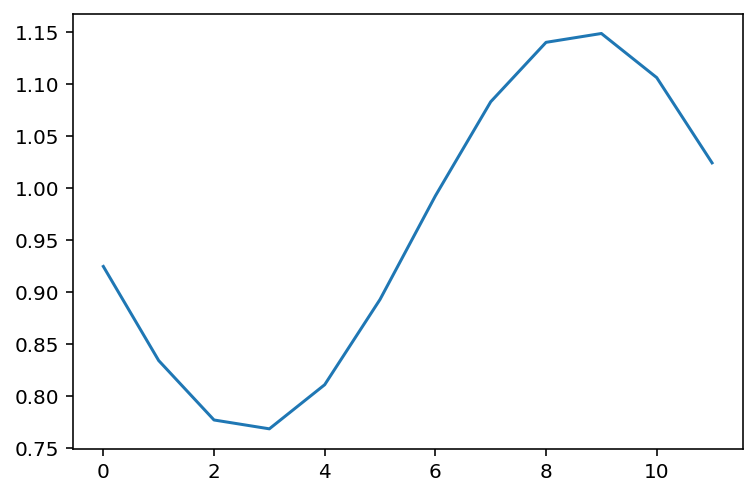

In [54]:
# We will use one harmonic
def phi(t):
    mt = 2*np.pi*t/12.
    return beta1h[1] + beta1h[2:] @ np.array([np.sin(mt), np.cos(mt)])
plt.plot(phi(np.arange(0,12)));

In [83]:
# fit AR(1) NOT periodic
from numpy.linalg import inv

y = n34a[1:].values
N = len(y)
X = np.empty((N,2)) + np.nan
X[:, 0] = 1.
X[:, 1] = n34a[0:-1]

beta_ar1 = inv(X.T@X)@X.T@y
print (beta_ar1)

[-0.00345865  0.95758981]


### 2.2 Periodic AR(1) forecasts


$$ E[ X_{t + \tau} | x_t]  = \phi(t + \tau) \times \dots \times \phi(t+1) x_t + k'$$


In [56]:
# nlead = max of tau
# nstart = number of starts
nlead = 12
nstart = len(n34a)

# Need a 2D (start and lead) array for the forecasts
# It is handy to arrange the corresponding observations in the same format
f = np.full((nlead, nstart), np.nan)
f_ar1 = np.full((nlead, nstart), np.nan)
o = np.full((nlead, nstart), np.nan)

In [108]:
# Start time t and lead time tau
t = np.arange(0, nstart)
tau = np.arange(1, nlead + 1)

In [110]:
f[0, :] = phi(t + tau[0]) * n34a + beta1h[0]
o[0, :] = n34a.shift(T = -1)
f_ar1[0, :] = 0.95 * n34a.values 

for ilead in range(1, nlead):
    f[ilead, :] = phi(t + tau[ilead]) * f[ilead - 1, :] + beta1h[0]
    f_ar1[ilead, :] = beta_ar1[1] * f_ar1[ilead - 1, :] + beta_ar1[0]
    o[ilead, :] = n34a.shift(T = -(ilead + 1)).values

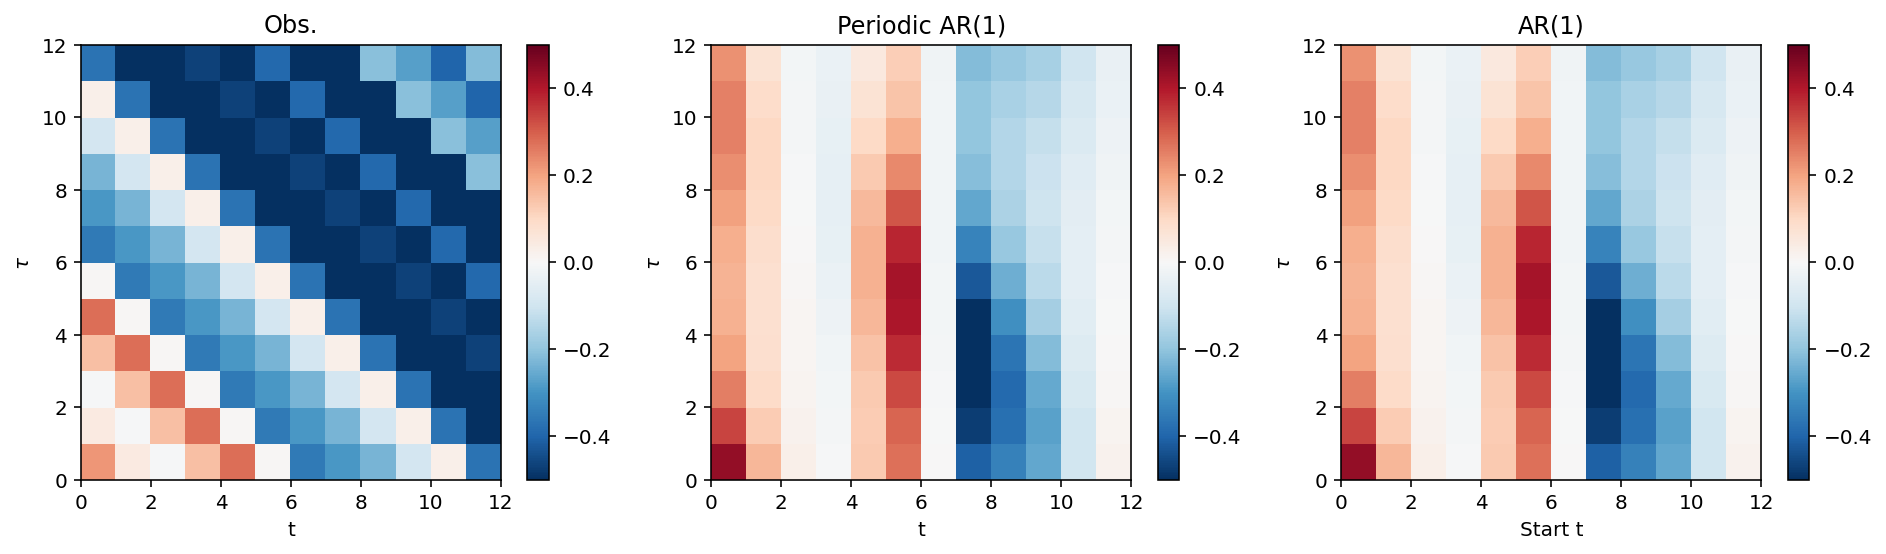

In [59]:
fig, ax = plt.subplots(1,3, figsize = (16, 4))

g = ax[0].pcolormesh(o[:, :12], vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
ax[2].set_xlabel('Start t')
ax[0].set_xlabel('t')
ax[0].set_ylabel(r'$\tau$');
ax[0].set_title('Obs.')
plt.colorbar(g, ax = ax[0]);

g = ax[1].pcolormesh(f[:, :12], vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
ax[1].set_xlabel('Start t')
ax[1].set_xlabel('t')
ax[1].set_ylabel(r'$\tau$')
ax[1].set_title('Periodic AR(1)')
plt.colorbar(g, ax = ax[1]);

g = ax[2].pcolormesh(f[:, :12], vmin = -0.5, vmax = 0.5, cmap = 'RdBu_r')
ax[2].set_xlabel('Start t')
ax[2].set_ylabel(r'$\tau$')
ax[2].set_title('AR(1)')
plt.colorbar(g, ax = ax[2]);

### 2.3 Skill of AR(1) and periodic AR(1) by lead

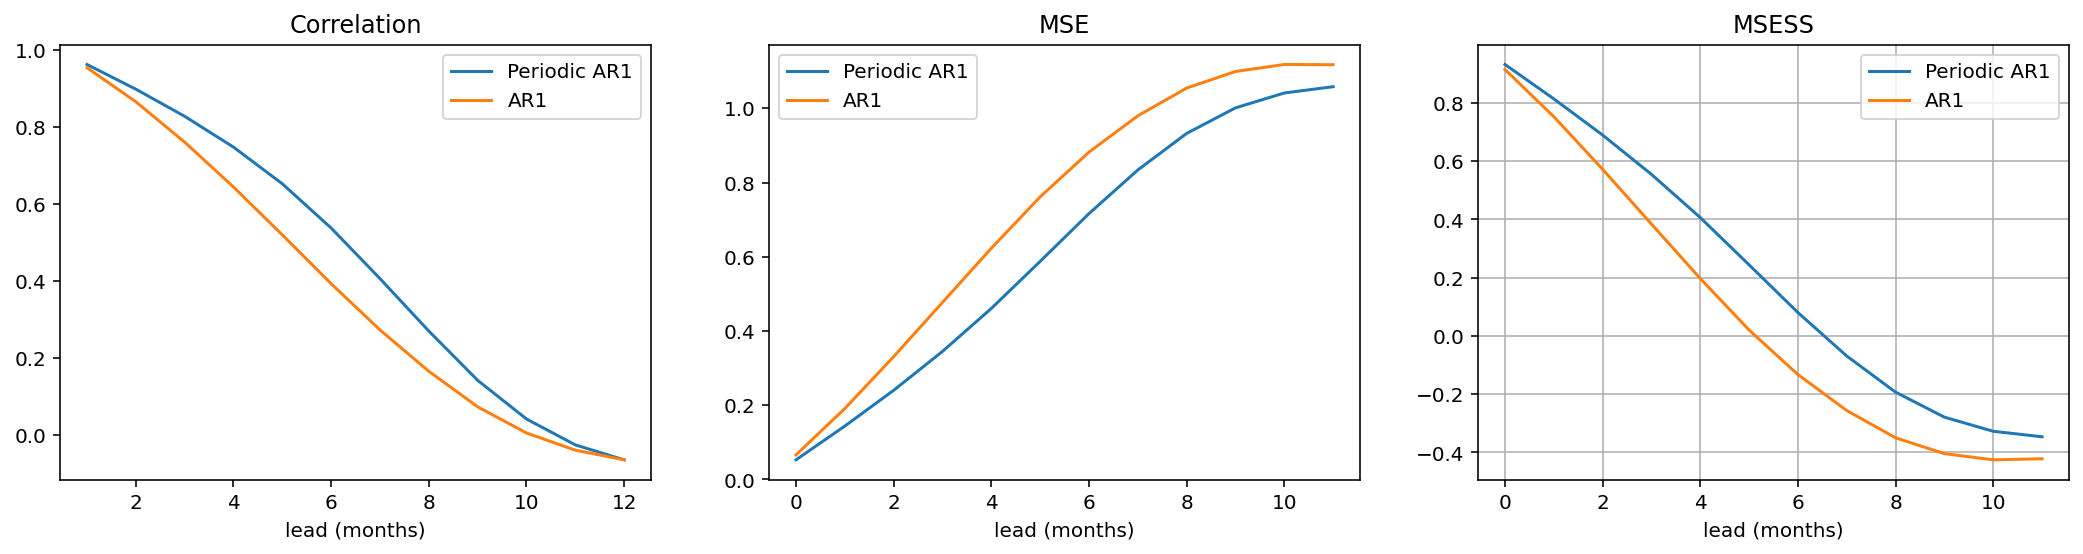

In [97]:
AC = np.empty(12) + np.nan
MSE = np.empty(12) + np.nan
MSESS = np.empty(12) + np.nan

AC_ar1 = np.empty(12) + np.nan
MSE_ar1 = np.empty(12) + np.nan
MSESS_ar1 = np.empty(12) + np.nan



for ilead in range(0, nlead):
    AC[ilead] = cor(f[ilead,:], o[ilead,:])
    MSE[ilead] = np.nanmean((f[ilead,:] - o[ilead,:])**2)
    MSESS[ilead] = 1 - np.nanmean((f[ilead,:] - o[ilead,:])**2)/np.nanmean((o[ilead,:])**2)
    AC_ar1[ilead] = cor(f_ar1[ilead,:], o[ilead,:])
    MSE_ar1[ilead] = np.nanmean((f_ar1[ilead,:] - o[ilead,:])**2)
    MSESS_ar1[ilead] = 1 - np.nanmean((f_ar1[ilead,:] - o[ilead,:])**2)/np.nanmean((o[ilead,:])**2)

fig, ax = plt.subplots(1,3, figsize = (18, 4))
lead = np.arange(1, nlead + 1)
ax[0].plot(lead, AC, label = 'Periodic AR1')
ax[0].plot(lead, AC_ar1, label = 'AR1')
ax[0].set_title('Correlation')
#plot_acf(n34a, alpha = None, ax = ax[0])

ax[1].plot(MSE, label = 'Periodic AR1');
ax[1].plot(MSE_ar1, label = 'AR1');
ax[1].set_title('MSE')

ax[2].plot(MSESS, label = 'Periodic AR1');
ax[2].plot(MSESS_ar1, label = 'AR1');
ax[2].set_title('MSESS')
ax[2].grid()

for ii in range(0, 3):
    ax[ii].set_xlabel('lead (months)')
    ax[ii].legend()
fig.set_facecolor("white")

But this doesn't tell the complete story

### 2.4 Skill of AR(1) and periodic AR(1) by start month and lead

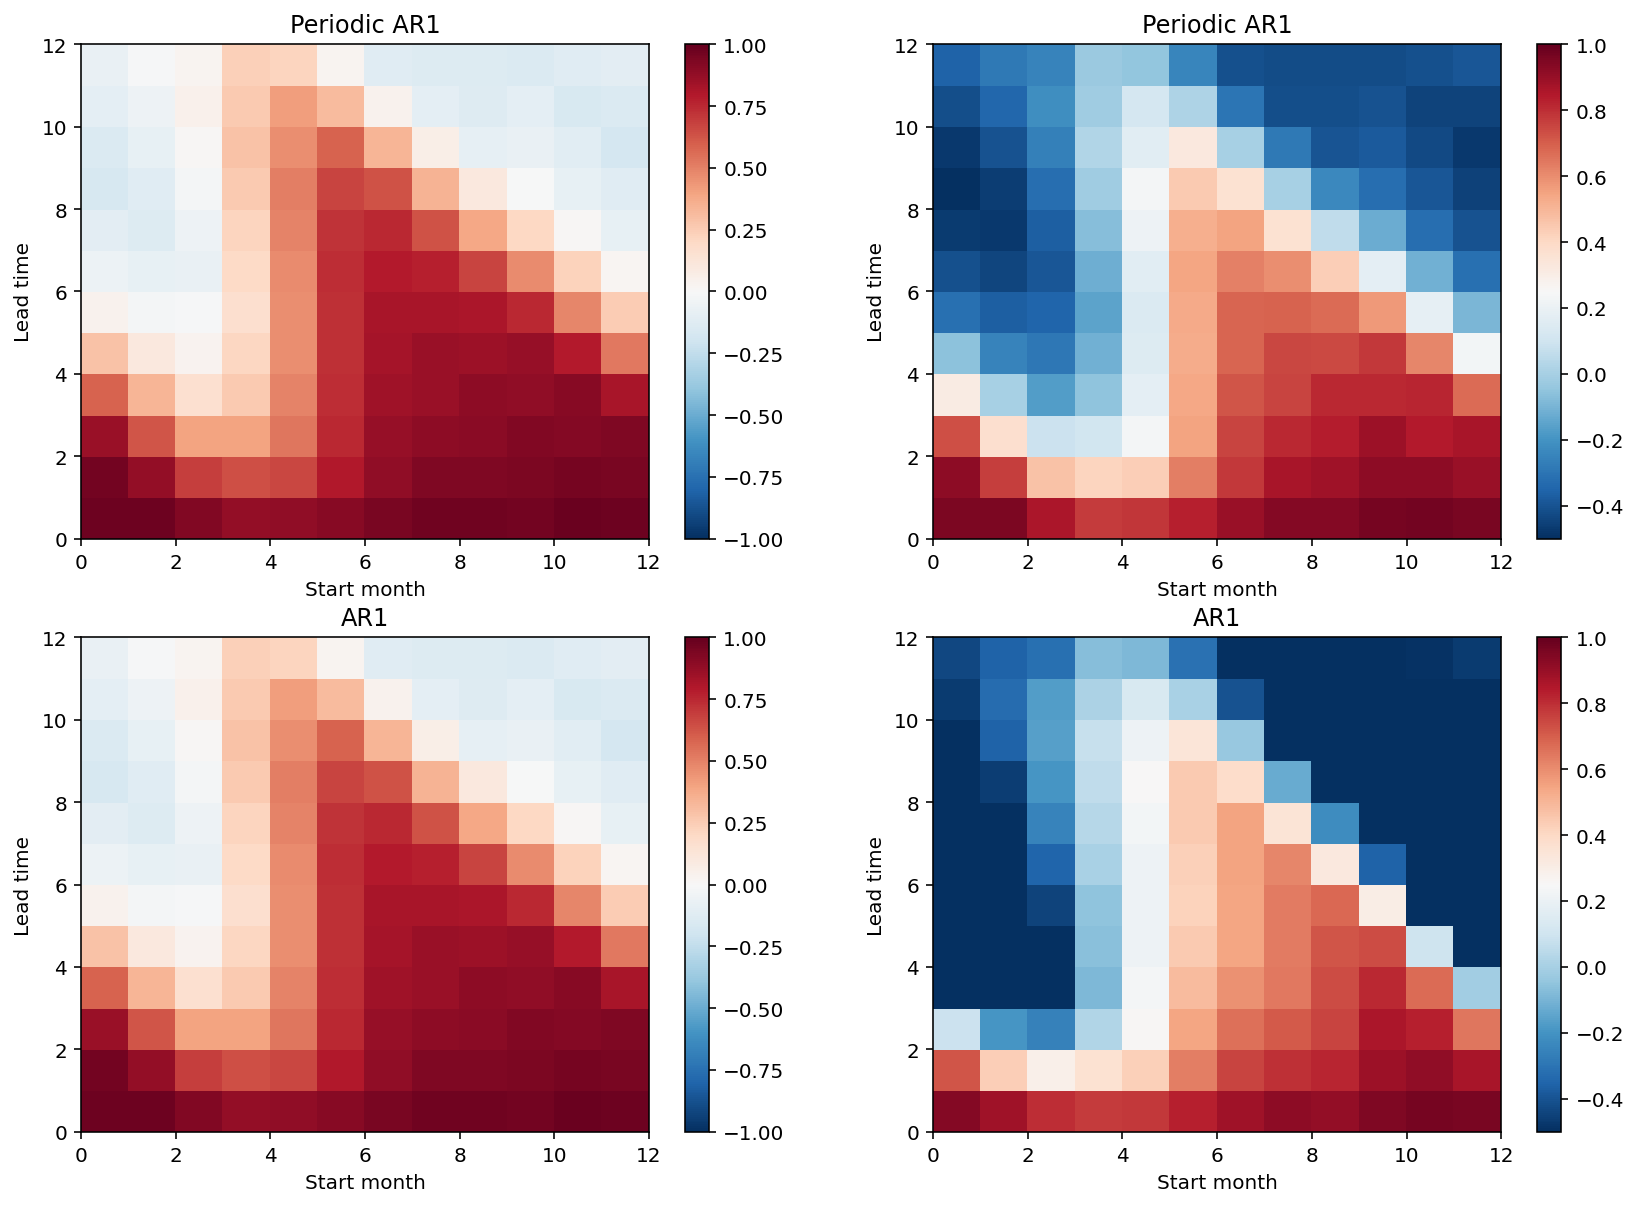

In [106]:
AC12 = np.full((12, 12), np.nan)
MSESS12 = np.full((12, 12), np.nan)
AC12_ar1 = np.full((12, 12), np.nan)
MSESS12_ar1 = np.full((12, 12), np.nan)
var12 = np.full((12, 12), np.nan)

for ii in range(0, 12):
    for jj in range(0, 12):
        f0 = f[ii, jj::12]
        o0 = o[ii, jj::12] 
        AC12[ii, jj] = cor(f0, o0)
        MSESS12[ii, jj] = 1 - np.nanmean((f0 - o0)**2)/np.nanmean((o0)**2)
        var12[ii,jj] = np.var(f0)
        f0 = f_ar1[ii, jj::12]
        o0 = o[ii, jj::12]
        AC12_ar1[ii, jj] = cor(f0, o0)
        MSESS12_ar1[ii, jj] = 1 - np.nanmean((f0 - o0)**2)/np.nanmean((o0)**2)

fig, axs = plt.subplots(2, 2, figsize = (14, 10))        

ax = axs[0,0]
g = ax.pcolormesh(AC12, vmin = -1, vmax = 1, cmap = 'RdBu_r');
ax.set_xlabel('Start month')
ax.set_ylabel('Lead time')
ax.set_title('Periodic AR1')
plt.colorbar(g, ax = ax)

ax = axs[0,1]
g = ax.pcolormesh(MSESS12, vmin = -0.5, vmax = 1, cmap = 'RdBu_r');
ax.set_xlabel('Start month')
ax.set_ylabel('Lead time')
ax.set_title('Periodic AR1')
plt.colorbar(g, ax = ax);

ax = axs[1,0]
g = ax.pcolormesh(AC12_ar1, vmin = -1, vmax = 1, cmap = 'RdBu_r');
ax.set_xlabel('Start month')
ax.set_ylabel('Lead time')
ax.set_title('AR1')
plt.colorbar(g, ax = ax)

ax = axs[1,1]
g = ax.pcolormesh(MSESS12_ar1, vmin = -0.5, vmax = 1, cmap = 'RdBu_r');
ax.set_xlabel('Start month')
ax.set_ylabel('Lead time')
ax.set_title('AR1')
plt.colorbar(g, ax = ax);

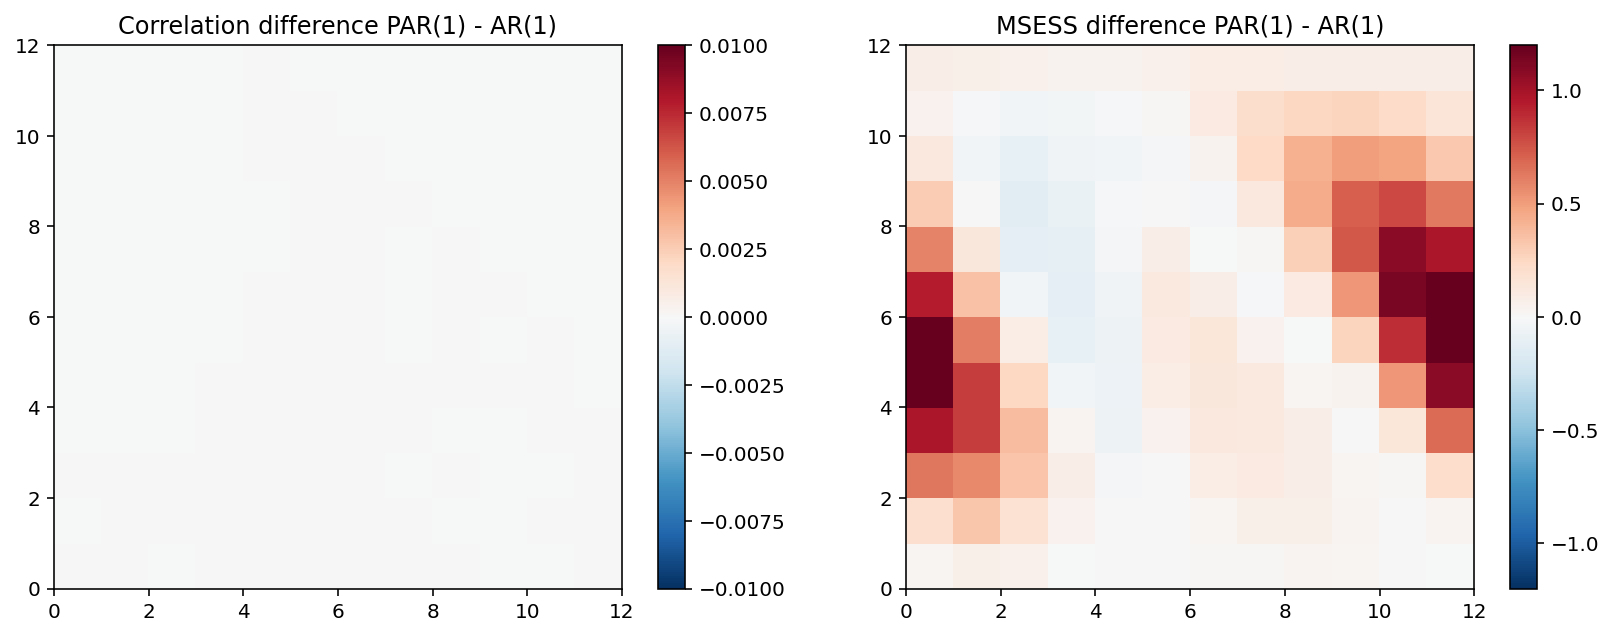

In [75]:
fig, axs = plt.subplots(1, 2, figsize = (14,5))        

ax = axs[0]
g = ax.pcolormesh(AC12 - AC12_ar1, vmin = -.01, vmax = .01, cmap = 'RdBu_r');
plt.colorbar(g, ax = ax)
ax.set_title('Correlation difference PAR(1) - AR(1)');

ax = axs[1]
g = ax.pcolormesh(MSESS12 - MSESS12_ar1, vmin = -1.2, vmax = 1.2, cmap = 'RdBu_r');
plt.colorbar(g, ax = ax)
ax.set_title('MSESS difference PAR(1) - AR(1)');

## 3. Periodic AR2

### 3.1 Model
$$ X_t = \phi_1(t) X_{t-1} + \phi_2(t) X_{t-2} + W_t $$

with 

$$\phi_1(t) = a_0 + a_1 \sin( 2 \pi t /12) + b_1 \cos( 2 \pi t/12) $$

$$\phi_2(t) = c_0 + d_1 \sin( 2 \pi t /12) + e_1 \cos( 2 \pi t/12) $$

### 3.2 Fit

In [113]:
# one harmonic in Fourier series
from numpy.linalg import inv

t_first = 2
y = n34a[t_first:].values
N = len(y)

mt = np.arange(2, N + t_first)/12.*2*np.pi

X = np.empty((N,7)) + np.nan
X[:, 0] = 1.
X[:, 1] = n34a[1:-1]
X[:, 2] = n34a[1:-1] * np.sin(mt)
X[:, 3] = n34a[1:-1] * np.cos(mt)
X[:, 4] = n34a[0:-2]
X[:, 5] = n34a[0:-2] * np.sin(mt)
X[:, 6] = n34a[0:-2] * np.cos(mt)

beta_par2 = inv(X.T@X)@X.T@y

array([-0.00261825,  1.33329418, -0.1035711 , -0.19614031, -0.392816  ,
       -0.02320499,  0.18250212])

In [64]:
def phi1(t):
    mt = 2*np.pi*t/12.
    return beta_par2[1:4] @ np.array([np.ones_like(mt), np.sin(mt), np.cos(mt)])

def phi2(t):
    mt = 2*np.pi*t/12.
    return beta_par2[4:] @ np.array([np.ones_like(mt), np.sin(mt), np.cos(mt)])

(490,)

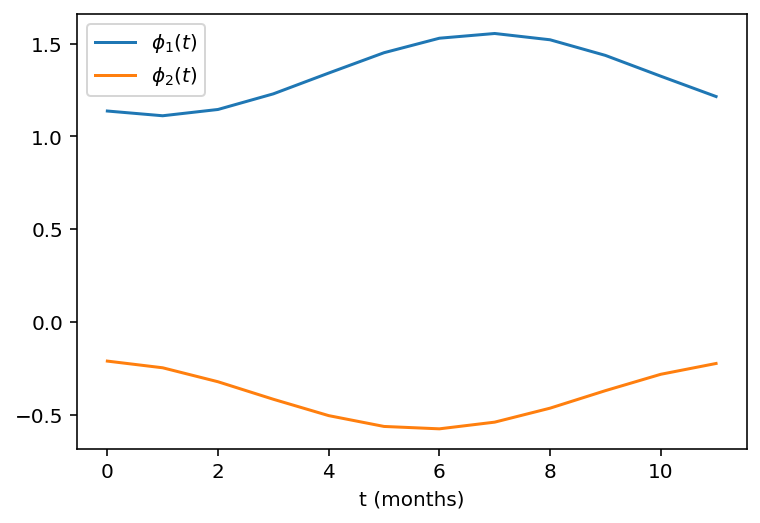

In [196]:
plt.plot(phi1(np.arange(0,12)), label = '$\phi_1(t)$')
plt.plot(phi2(np.arange(0,12)), label = '$\phi_2(t)$')
plt.xlabel('t (months)')
plt.legend();

# Exercises

## 1. (10 points) Comparing the skill of AR(1) and periodic AR(1) forecasts

A. For which starts and lead times is the MSESS of the periodic AR(1) forecasts higher than that of the AR(1) forecasts?  ***The periodic forecast MSESS is greater than that on the non-periodic model with forecasts that begin in the Fall and Winter months. The range of lead times where this difference is most clearly pronounced is between 6-10 months during the fall, and decreasing to 2-8 months in the winter.***  
B. Plotted as a function of lead time only, the correlation skill of the periodic AR(1) forecasts is higher than that of the AR(1) forecasts. However, plotted as function of start and lead, their correlation skill appears indistingueable? Explain how this is possible or find the error in the calculation.   
***When one is taking into account both starting month and lead month, one is applying the equation as stated at the beginning of 2.1 to a set of X0 only dependent on year, or rather taking every 12th value from the total dataset. Therefore, the value for phi in this equation is constant over the dataset for which we are taking the correlation. As stated in explaining why AR(1) correlation to observed was the same as the autocorrelation, applying some constant multiplier to one variable in a correlation, as long as that multiplier is positive, does not change the correlation. Because phi is constant for the dataset given a single t and tau, the correlation between the projection for the set of all such X0 with a given tau and the observed values is also identical to the autocorrelation. This fails, however, when one takes the correlation over the entirety of t, even given a particular tau. Here, phi is still constant for all starting values for the AR(1) model, and thus the correlation is still identical to that of the ACF; however, phi changes dependent on t for the periodic function, changing the correlation from that of the ACF, and therefore from that of the normal AR(1).***

## 2. (25 points) Consider a mean-zero periodic AR(1) model:

$$ X_t = \phi(t) X_{t-1} + W_t $$

with $\phi(t + 12) = \phi(t)$ and Gaussian white noise $W_t \sim N(0, \sigma_W^2)$. Define the variance vector $v$ by

$$ v_t = 
\begin{bmatrix}
\text{var} [ X_t ] \\
\text{var} [ X_{t+1} ] \\
\vdots \\
\text{var} [ X_{t+10} ] \\
\text{var} [ X_{t+11} ] \\
\end{bmatrix}
\,,$$
and assume that $v_{t + 12} = v_t$.

A. (5 Points) Find the matrix $A_t$ and the vector $b$ such that 

$$ A_t v_t = b \,.$$ and show that $A_t = A_{t+12}$.  
**See attached picture for part A. Note that I am using incorrect notation with the phis, using the subscript instead of a function argument - this made it easier to save space - but if one keeps in mind that what I have as subscripts I take to mean the function argument, the math should still work. It is clear from the matrix, visually, that if we take for granted that phis, Xts, and variances are cyclical, then A must also me. If we were to replace the Xt at the top of V with a Xt+12 at the bottom of it, then to satisfy each equation, given the cyclical nature of each v, then there must similarly be an extra column added to the right of A that is a copy of the leftmost column of the original, itself then removed. Thus as v 'shifts' in a way, so does A. Repeat this process 12 times and V will come to the original formation, and A will also rotate back to its original position.**

B. (5 points) Use (Gaussian) elimation to arrive at $Lv = b'$ where $L$ is a lower-triangular matrix and $b'$ is the new right hand side. State a necessary condition on the $\phi$'s so that $L$ is invertible and that the solution $v$ is positive, as variances should be. 
 **Again, see attached picture. The condition for each phi is that they must all be non-zero and have magnitude less than one (there may be a less restrictive definition but having all of the phis' magnitudes less than one should do the trick.**
 

C. (5 points) For the $\phi$'s and $\sigma_W^2$ of the periodic AR(1) model for Nino 3.4 computed above, solve for $v$ numerically. Plot $v$ along with the variance of Nino 3.4 by month.

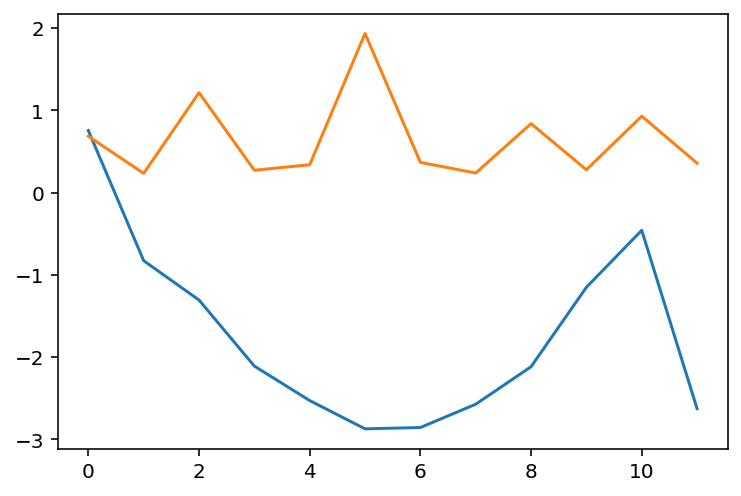

In [251]:
def product_phis(x,y):
    temp = 1
    if y == 11:
        return 1
    else:
        for ii in range (0,y):
            temp = temp/((phi(x-ii))**2)
        return temp
        
    
    
    
A = np.zeros((12,12))
for ii in range (0,12):
    A[ii,ii]= - (phi(ii+1))**2
    A[ii,0] = A[ii,0]+ product_phis(12,ii)
   
    
sigma_W_matrix = np.full((12,), 1)
for ii in range (0,11):
    for jj in range (ii, 12):
        sigma_W_matrix[11-ii] = sigma_W_matrix[11-ii] + product_phis(jj,ii)
sigma_W_matrix = sigma_W_matrix*sigma_W
n34a_plus = np.zeros(492,)
n34a_plus[range(0,n34a.size)] = n34a[range(0,n34a.size)]
v = inv(A)@sigma_W_matrix
plt.plot (v)
plt.plot (np.var(np.reshape(n34a_plus,(12,-1)), axis = 1))

D. (5 points) Write $X_{t+\tau}$ in terms of $X_t$ and noise terms $W_{t+1}$, ..., $W_{t+\tau}$. Hint: first write $X_{t+\tau}$ in terms of $X_{t_\tau-1}$ and $W_{t+\tau}$, and then work your way back to $X_t$ and $W_{t+1}$.

E. (5 points) Derive an expression for $\text{cor} [X_t, X_{t+\tau}]$, $\tau > 0$. Plot it for $t = 0, ... 11$ and $\tau = 1, ..., 12$ using the parameters of the periodic AR(1) model fit to Nino 3.4. Hint: multiply both sides of the result of D by $X_t/\sqrt{\text{var} [v_t] \text{var} [v_{t+\tau}]}$, and take the expectation. 

![](Pictures/11_17_20.jpg)

## 3 (10 points) Use the periodic AR(2) model to forecast Nino 3.4 for the next 12 months.

Compare your forecasts with the [NMME forecasts](https://www.cpc.ncep.noaa.gov/products/NMME/current/plume.html). 

  *I don't know if we're supposed to do this comparison with NMME numerically (I doubt it) but they look somewhat similar to me!*

Text(0.5, 1.0, 'Nino 3.4 Predictions by Periodic AR2')

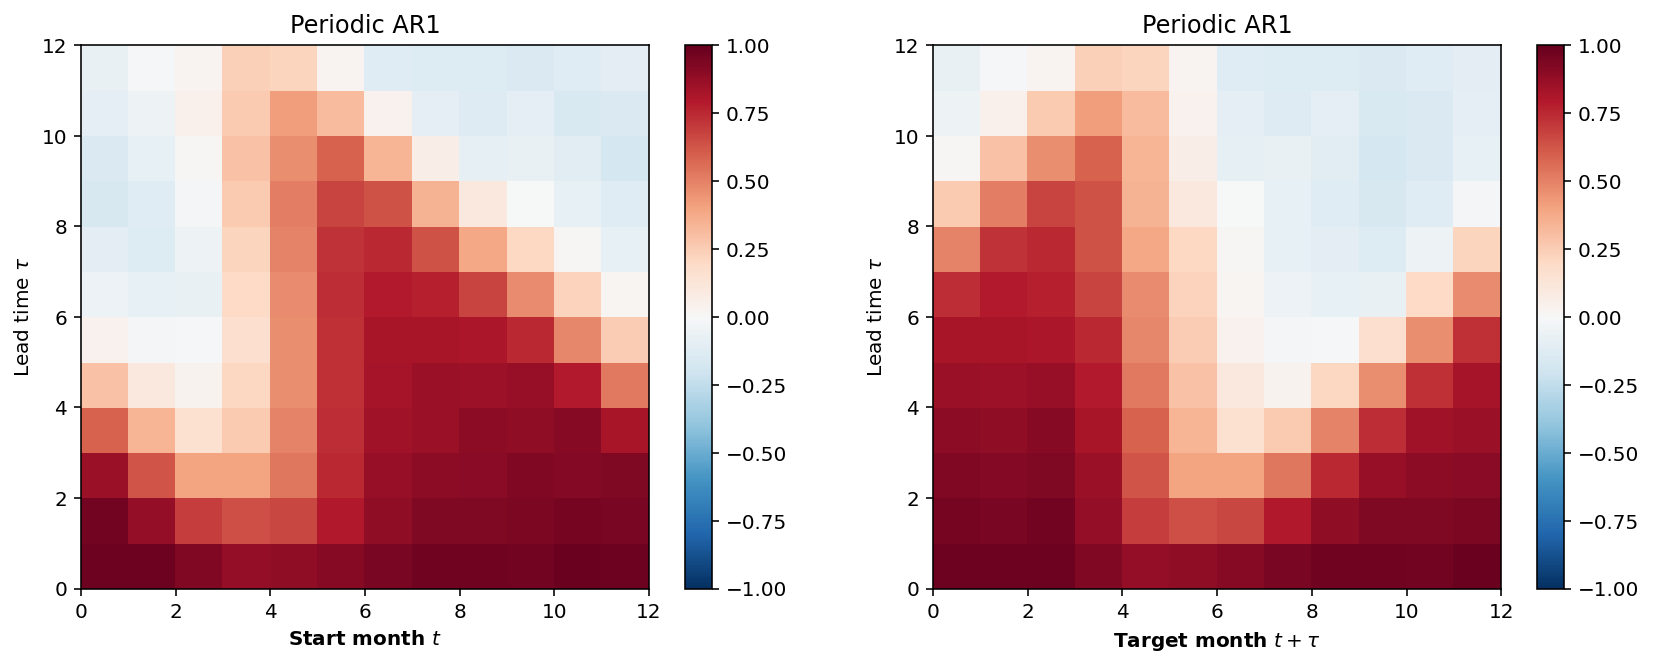

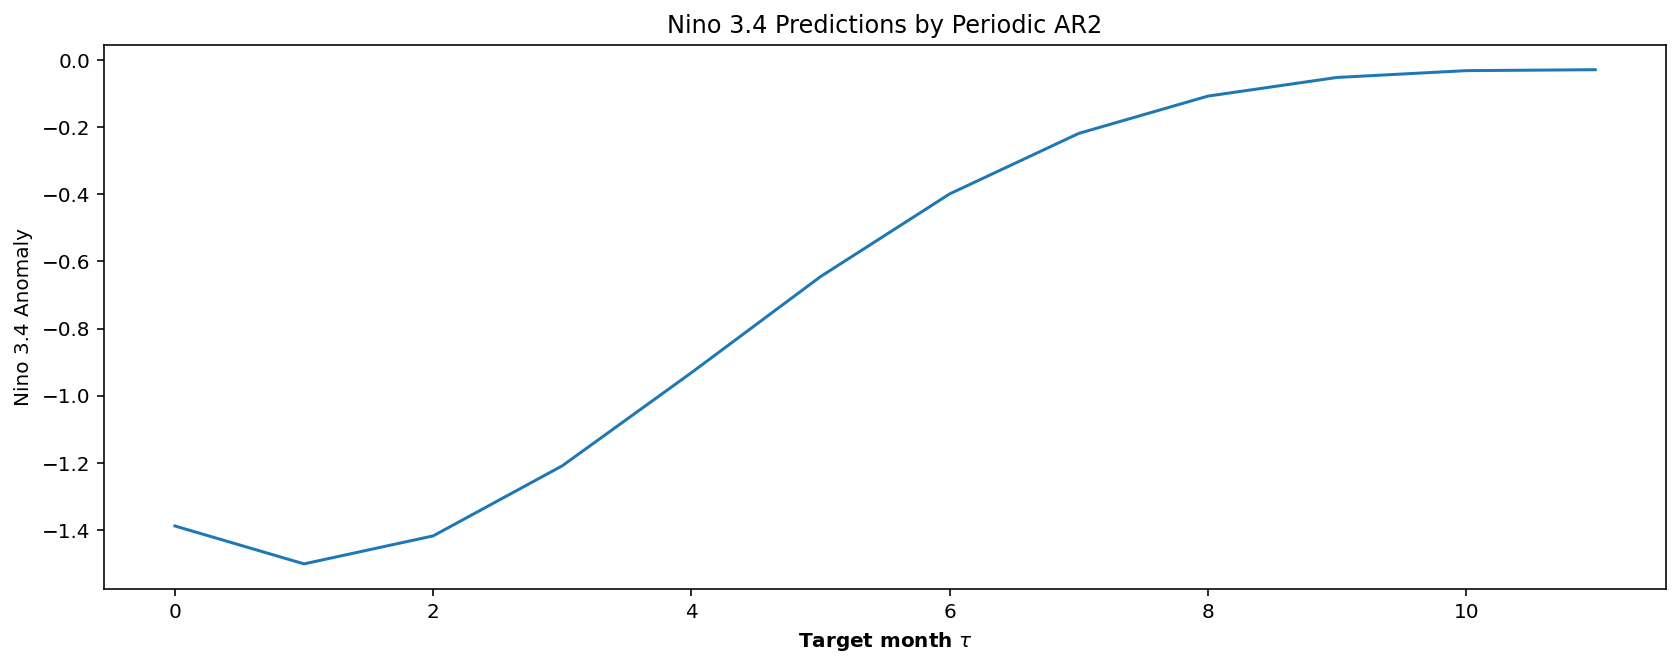

In [252]:
AC12_target = np.empty_like(AC12)
for ii in range(0, 12):
    AC12_target[ii, :] = np.roll(AC12[ii, :], ii + 1)
    
X_n1 = n34a[-1]
X_n2 = n34a[-2]
X_future = np.empty((12,)) + np.nan
X_future[0] = beta_par2[0] + X_n1*phi1(n34a.size%12)+X_n2*phi2(n34a.size%12)
X_future[1] = beta_par2[0] + X_future[0]*phi1(n34a.size%12)+X_n1*phi2(n34a.size%12)
for ii in range (2, 12):
    X_future[ii] = beta_par2[0] + X_future[ii-1]*phi1(n34a.size%12+ii)+X_future[ii-2]*phi2(n34a.size%12+ii)

fig, axs = plt.subplots(1, 2, figsize = (14, 5))
ax = axs[0]
g = ax.pcolormesh(AC12, vmin = -1, vmax = 1, cmap = 'RdBu_r');
ax.set_xlabel('Start month $t$', weight = 'bold')
ax.set_ylabel(r'Lead time $\tau$')
ax.set_title('Periodic AR1')
plt.colorbar(g, ax = ax)

ax = axs[1]
g = ax.pcolormesh(AC12_target, vmin = -1, vmax = 1, cmap = 'RdBu_r');
ax.set_xlabel(r'Target month $t + \tau$', weight='bold')
ax.set_ylabel(r'Lead time $\tau$')
ax.set_title('Periodic AR1')
plt.colorbar(g, ax = ax);
fig.set_facecolor("white")

fig, axs = plt.subplots(1, 1, figsize = (14, 5))
ax = axs
g = plt.plot(X_future)
ax.set_xlabel(r'Target month $\tau$', weight='bold')
ax.set_ylabel(r'Nino 3.4 Anomaly')
ax.set_title('Nino 3.4 Predictions by Periodic AR2')
